<span style="color:green">
<h2><b>Энергопотребление металлургического завода</b></h2>
</span>

<span style="color:green">
<h3>Условие задачи</h3>
Чтобы оптимизировать производственные расходы для металлургического комбината необходимо уменьшить потребление электроэнергии. Необходимо построить модель, которая предскажет температуру стали.<br><br>
Производственный процесс варки стали состоит из 4-х основных этапов:<br>
1. Измерение температуры расплава<br>
2. Повышение температуры расплава<br>
3. Загрузка в расплав сыпучих легирующих материалов и/или проволоки<br>
4. Продув расплава интертным газом<br>
<br>
Процесс поторяется до тех пор, пока не будет получена сталь с нужным химическим составом и температурой<br><br>
Для решения задачи приведены следующие данные:
- данные об электродах<br>
- данные о подаче сыпучих материалов (объём)<br>
- данные о подаче сыпучих материалов (время)<br>
- данные о продувке сплава газом<br>
- результаты измерения температуры<br>
- данные о проволочных материалах (объём)<br>
- данные о проволочных материалах (время)
</span>

<span style="color:green">
<h3><b>1. План работ</b></h3>
</span>

<span style="color:green">
Для начала импортируем все необходимые для первоначальной работы модули
</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from numpy.random import RandomState

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPRegressor

from sklearn.cluster import KMeans, DBSCAN

<span style="color:green">
Загрузим сразу все данные из файлов
</span>

In [2]:
try:
    data_arc = pd.read_csv('datasets/data_arc.csv')
    data_bulk = pd.read_csv('datasets/data_bulk.csv')
    data_bulk_time = pd.read_csv('datasets/data_bulk_time.csv')
    data_gas = pd.read_csv('datasets/data_gas.csv')
    data_temp = pd.read_csv('datasets/data_temp.csv')
    data_wire = pd.read_csv('datasets/data_wire.csv')
    data_wire_time = pd.read_csv('datasets/data_wire_time.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

<span style="color:green">
Начнем по очереди проверку таблиц
</span>

<span style="color:green">
1. Анализ данных по нагреву электродами
</span>

In [3]:
data_arc.head(2)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


<span style="color:green">
Есть заметный выброс по реактивной мощности - скорее всего она не может быть меньше нуля
</span>

In [6]:
# Переименуем столбцы для удобства
data_arc.rename(columns={'Начало нагрева дугой':'start_arc_heating', 'Конец нагрева дугой':'finish_arc_heating', 'Активная мощность':'active_power', 'Реактивная мощность':'reactive_power'}, inplace=True)

# Приведем даты к временному типу
data_arc['start_arc_heating'] = pd.to_datetime(data_arc['start_arc_heating'])
data_arc['finish_arc_heating'] = pd.to_datetime(data_arc['finish_arc_heating'])

In [7]:
# Посмотрим, сколько у нас строк с аномальными значениями

less_zero_arc = data_arc.query('reactive_power < 0')
print(f'Неправильное значение reactive_power: length: {len(less_zero_arc)},  indexes: {less_zero_arc.index}')

incorrect_time_arc = data_arc.query('start_arc_heating > finish_arc_heating')
print(f'Неправильное значение начального и конечного времен: length: {len(incorrect_time_arc)},  indexes: {incorrect_time_arc.index}')

Неправильное значение reactive_power: length: 1,  indexes: Int64Index([9780], dtype='int64')
Неправильное значение начального и конечного времен: length: 0,  indexes: Int64Index([], dtype='int64')


In [8]:
data_arc[data_arc['key'] == less_zero_arc['key'].values[0]]

,key,start_arc_heating,finish_arc_heating,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


<span style="color:green">
Скорее всего, аномальное значение можно исправить (оно всего одно, это явно ошибка датчика/внесения данных в таблицу), исходя из общей закономерности соотношения active_power, reactive_power, а также времени нагрева.<br>
Прикинем, как оно может выглядеть
</span>

In [9]:
relation = (data_arc['active_power'] - data_arc['reactive_power'])/(data_arc['finish_arc_heating'] - data_arc['start_arc_heating']).dt.total_seconds()

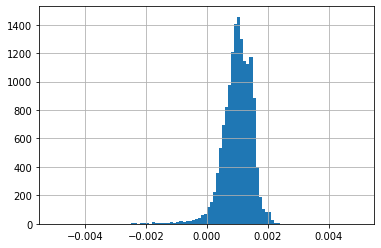

In [10]:
relation.hist(bins=100, range=(-0.005, 0.005));

In [11]:
data_arc.head(5)

,key,start_arc_heating,finish_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [12]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 14876 non-null  int64         
 1   start_arc_heating   14876 non-null  datetime64[ns]
 2   finish_arc_heating  14876 non-null  datetime64[ns]
 3   active_power        14876 non-null  float64       
 4   reactive_power      14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


<span style="color:green">
Распределение похоже на узкую гауссиану, поэтому восстановим значение из mean(relation)
</span>

In [13]:
mean = relation.mean()
data_arc.iloc[less_zero_arc.index[0], 4] = data_arc.iloc[less_zero_arc.index[0], 3] - mean*(data_arc.iloc[less_zero_arc.index[0], 2]-data_arc.iloc[less_zero_arc.index[0], 1]).total_seconds()

<span style="color:green">
2. Данные о подаче сыпучих материалов (объём)
</span>

In [14]:
data_bulk.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0


In [15]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


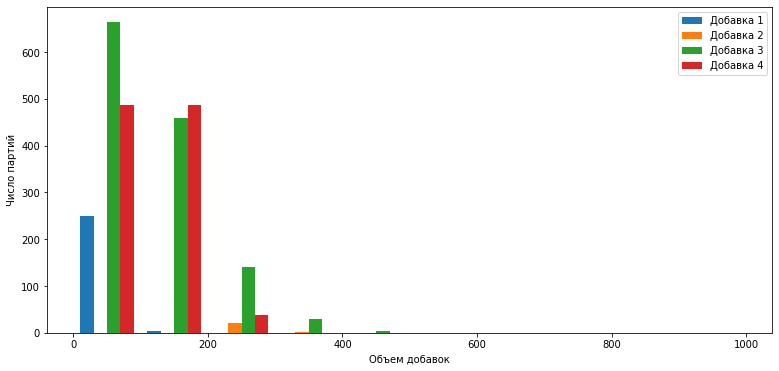

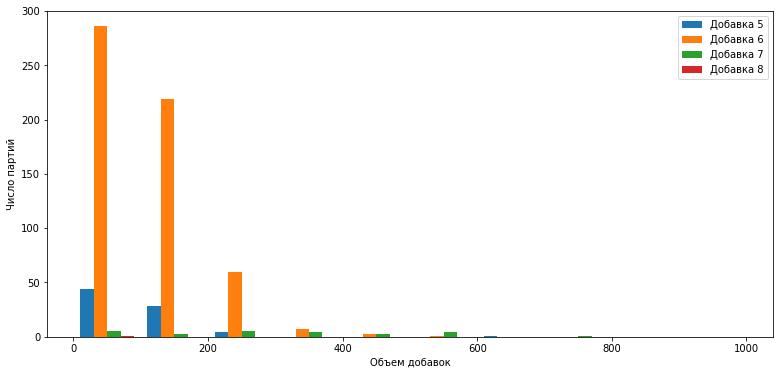

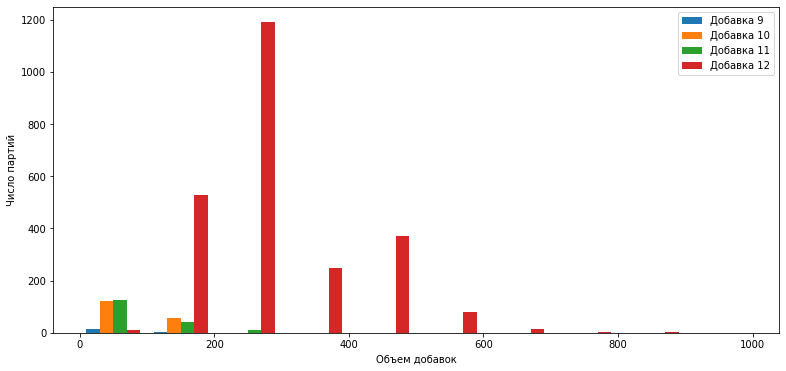

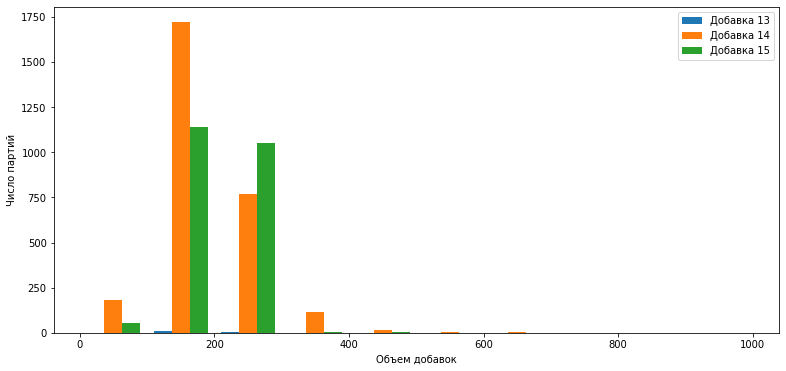

In [17]:
plt.figure(figsize=(13,6))
plt.hist([list(data_bulk.iloc[:,1]), list(data_bulk.iloc[:,2]), list(data_bulk.iloc[:,3]), list(data_bulk.iloc[:,4])], bins=10, range=(0, 1000));
plt.legend(['Добавка 1', 'Добавка 2', 'Добавка 3', 'Добавка 4']);
plt.xlabel('Объем добавок');
plt.ylabel('Число партий');
plt.figure(figsize=(13,6))
plt.hist([list(data_bulk.iloc[:,5]), list(data_bulk.iloc[:,6]), list(data_bulk.iloc[:,7]), list(data_bulk.iloc[:,8])], bins=10, range=(0, 1000));
plt.legend(['Добавка 5', 'Добавка 6', 'Добавка 7', 'Добавка 8']);
plt.xlabel('Объем добавок');
plt.ylabel('Число партий');
plt.figure(figsize=(13,6))
plt.hist([list(data_bulk.iloc[:,9]), list(data_bulk.iloc[:,10]), list(data_bulk.iloc[:,11]), list(data_bulk.iloc[:,12])], bins=10, range=(0, 1000));
plt.legend(['Добавка 9', 'Добавка 10', 'Добавка 11', 'Добавка 12']);
plt.xlabel('Объем добавок');
plt.ylabel('Число партий');
plt.figure(figsize=(13,6))
plt.hist([list(data_bulk.iloc[:,13]), list(data_bulk.iloc[:,14]), list(data_bulk.iloc[:,15])], bins=10, range=(0, 1000));
plt.legend(['Добавка 13', 'Добавка 14', 'Добавка 15']);
plt.xlabel('Объем добавок');
plt.ylabel('Число партий');

<span style="color:green">
На первом графике можно видеть, что легирующая добавка №2 всречается реже 1, 3 и 4-ой<br>
На втором графике - все добавки встречаются в очень редких случаях, но 5-ая, 7-ая и 8-ая - минимальны даже в этом квартете<br>
На третьем графике - преимущество у легирующей добавки 12, самая редкая - 9-ая<br>
Четвертый график показывает, что легирующая добавка №13 самая редкая из заключительной тройки
</span>

<span style="color:green">
Особых аномалий в значениях нет, NaN можно заменить на 0 (легирующая добавка не добавлялась), далее можно посмотреть частотность добавки легирующих материалов и убрать те, которые редко где добавлялись
</span>

In [18]:
data_bulk.columns = data_bulk.columns.str.lower()
data_bulk.columns = data_bulk.columns.str.replace(' ', '_')
data_bulk.fillna(0, inplace=True)

<span style="color:green">
Предположим, что мы будем удалять данные с редкими легирующими добавками (меньше ста строк с применением легирующей добавки). Оценим, насколько сильно уменьшится наша выборка, если выбросить их, оставив данные о часто добавляемых легирующих добавках (т.е. важно как много было случаев выплавки стали из исключительно редких легирующих добавок)
</span>

In [19]:
rare_columns = ['bulk_2', 'bulk_5', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13']

data_bulk_rare = data_bulk[rare_columns]
data_bulk_rare['sum'] = data_bulk_rare.sum(axis=1)
data_bulk_common = data_bulk.drop(rare_columns, axis=1)
data_bulk_common = data_bulk_common.drop(['key'], axis=1)
data_bulk_common['sum'] = data_bulk_common.sum(axis=1)

cntr = 0
for i in range(len(data_bulk)):
    if data_bulk_rare.iloc[i, 6] != 0 and data_bulk_common.iloc[i, 9] == 0:
        cntr += 1

print(f'Pure rare operations: {cntr}')
    

Pure rare operations: 10


<ipython-input-19-2edbbb430fbc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bulk_rare['sum'] = data_bulk_rare.sum(axis=1)


<span style="color:green">
В общем, столбцы с добавками совсем уж редких легирующих материалов можно удалить. А также удалить все строки, где были добавки совсем уж редких легирующих материалов
</span>

In [20]:
data_bulk = data_bulk.drop(rare_columns, axis=1)
data_bulk = data_bulk.drop(data_bulk[data_bulk.sum(axis=1) == data_bulk['key']].index)
data_bulk = data_bulk.reset_index(drop=True)

In [21]:
data_bulk.head(5)

,key,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0


In [22]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3119 entries, 0 to 3118
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3119 non-null   int64  
 1   bulk_1   3119 non-null   float64
 2   bulk_3   3119 non-null   float64
 3   bulk_4   3119 non-null   float64
 4   bulk_6   3119 non-null   float64
 5   bulk_10  3119 non-null   float64
 6   bulk_11  3119 non-null   float64
 7   bulk_12  3119 non-null   float64
 8   bulk_14  3119 non-null   float64
 9   bulk_15  3119 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 243.8 KB


<span style="color:green">
3. Данные о подаче сыпучих материалов (время)
</span>

In [23]:
data_bulk_time.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20


In [24]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [25]:
data_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<span style="color:green">
Как можно видеть, в данных этой таблицы стоят времена, когда легирующие добавки были добавлены в расплав. С другой стороны, вряд ли эти данные нам смогут как-либо помочь, потому что если посмтреть в данные - времена работы электродов, времена замера температуры и времена добавления легирующих материалов в расплав, то можно увидеть, что они все несинхронизированы. Поэтому в этом случае уже нет смысла проверять физическую точность модели варки стали (то есть соответсвие циклу - поднятие температуры->добавление примесей->газация->измерение температуры), и достаточно проверять данные по объемам добавленных материалов, приложенной мощности к электродам и суммарной длительности процесса. Таким образом, данные из таблицы <b>data_bulk_time</b> в дальнейшем рассматриваться не будут
</span>

<span style="color:green">
4. Данные о данные о продувке сплава газом
</span>

In [26]:
data_gas.head(2)

,key,Газ 1
0,1,29.749986
1,2,12.555561


In [27]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [28]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<span style="color:green">
Итак, здесь даны только номера партий, в которых использовался определенный объем газа, для пропускания его через расплав. Отметим, что число строк в таблице равно 3239, в то время как максимальный номер партии 3241 - то есть в каких-то партиях газирования расплава не было, что нарушает технологический процесс и впредь мы должни использовать отсюда номера <b>key</b>, чтобы с гарантией использовать только те номера партий, где использовался газ<br><br>
Дополнительно поправим название второго столбца
</span>

In [29]:
data_gas = data_gas.rename(columns={'Газ 1': 'gas'})

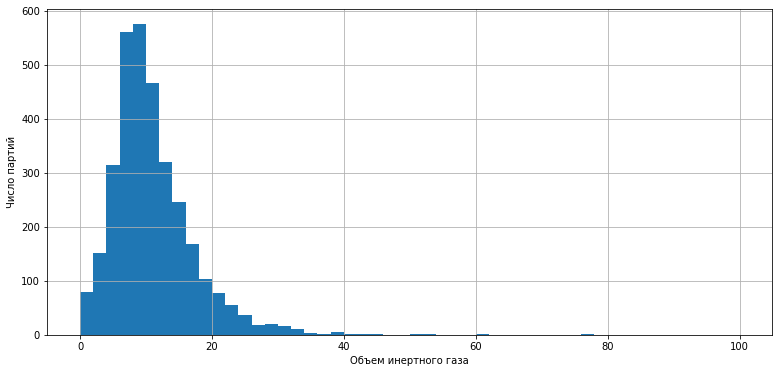

In [30]:
plt.figure(figsize=(13,6))
data_gas['gas'].hist(bins=50, range=(0,100));
plt.xlabel('Объем инертного газа');
plt.ylabel('Число партий');

<span style="color:green">
Видно, что распределение объемов инертного газа по партиям близко к номальному с матожиданием около 10 условных единиц объема
</span>

<span style="color:green">
5. Результаты измерения температуры
</span>

In [31]:
data_temp.head(2)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0


In [32]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [33]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


<span style="color:green">
Первые и самые важные выводы - в ряде случаев температура не замерялась вообще. Причем число пропусков таково, что вряд ли имеет смысл их восстанавливать по интерполяции, так как слишком большое число восстановлений может сильно исказить результаты в будущем. Второе - нужно убрать те партии, где в итоге был только один замер температуры<br>
Второй момент - у нас есть очень низкие значения температур (1191 градусов, например), которые явно ошибочны, так как явно ниже температуры плавления стали - она не меньше 1500 градусов по Цельсию
</span>

In [34]:
data_temp = data_temp.rename(columns={'Время замера':'time', 'Температура':'temperature'})
data_temp['time'] = pd.to_datetime(data_temp['time'])

In [35]:
# Оценим, сколько значений меньше реальной температуры плавления
print(len(data_temp.query('temperature < 1500')))

7


<span style="color:green">
Всего семь аномальных значений. Можно убрать их из таблицы
</span>

In [36]:
data_temp = data_temp.drop(data_temp.query('temperature < 1500').index)

In [37]:
# Узнаем, в каких партиях измерение температуры производилось несколько раз(!)
help_temp = data_temp.groupby(['key'])['temperature'].count()
help_temp = help_temp.reset_index()

good_keys_1 = help_temp.query('temperature >=2')['key'].values
print(f'Number of good keys {len(good_keys_1)}')

Number of good keys 2475


In [38]:
# Оставим только такие данны, где есть минимум два температурных замера
data_temp_filtered = data_temp.query('key in @good_keys_1')

<span style="color:green">
Теперь оставим номера только тех партий, где есть <b>первая</b> и <b>последняя</b> последняя температура замера(!)
</span>

In [39]:
first_last_temp_temp = data_temp_filtered.groupby(['key'])['temperature'].agg(['first', 'last']).reset_index()
first_last_temp_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2475 non-null   int64  
 1   first   2475 non-null   float64
 2   last    2475 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.1 KB


<span style="color:green">
Количество партий, где выполняется требуемое нами условие не изменилось. Остается только забрать список номеров партий <b>key</b>
</span>

In [40]:
good_keys = first_last_temp_temp['key'].values

<span style="color:green">
Итоговый вид <b>data_temp</b> c <b>good_keys</b>
</span>

In [41]:
watch = data_temp.query('key in @good_keys')
watch.head(10)

,key,time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [42]:
watch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12259 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          12259 non-null  int64         
 1   time         12259 non-null  datetime64[ns]
 2   temperature  12259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.1 KB


<span style="color:green">
Итак, для дальнейшей работы нам понадобятся номера партий <b>good_keys</b> и <b></b> из таблицы по газации расплавов
</span>

<span style="color:green">
6. Данные о проволочных материалах (объём)
</span>

<span style="color:green">
В принципе, анализ по добавлению проволоки в расплав повторяет анализ добавления сыпучих легирующих добавок
</span>

In [45]:
data_wire.head(2)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [47]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


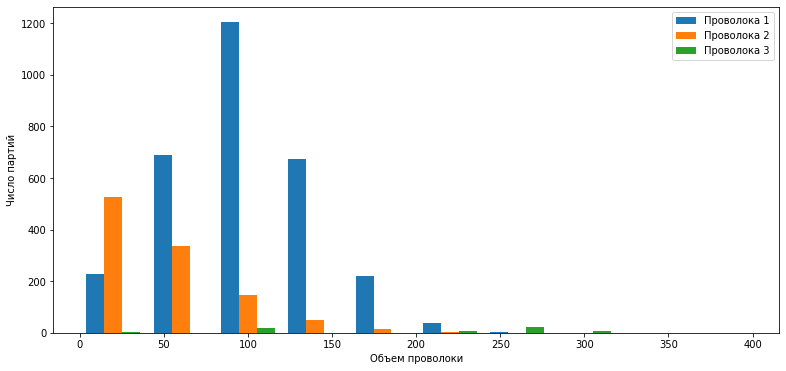

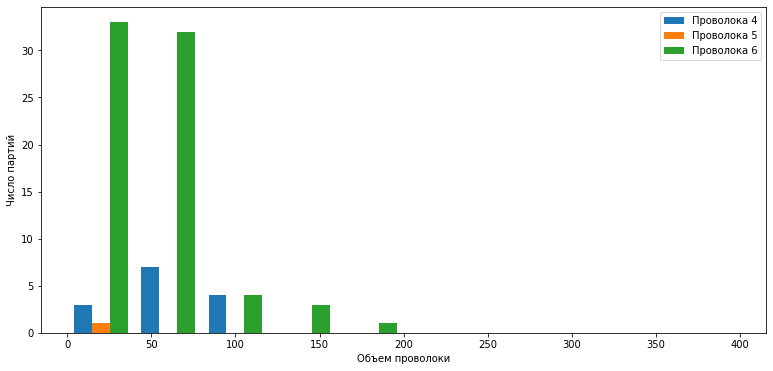

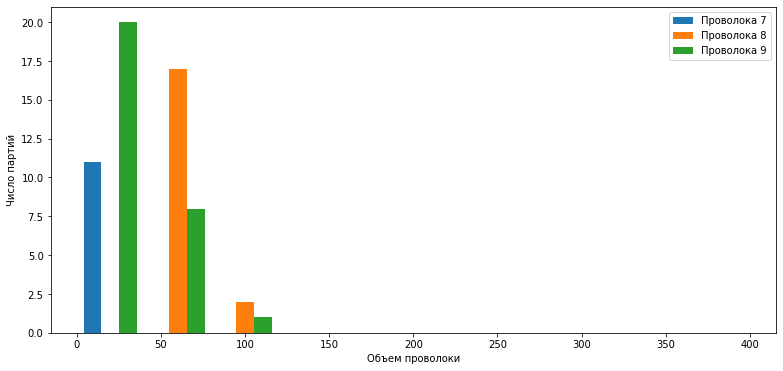

In [48]:
plt.figure(figsize=(13,6))
plt.hist([list(data_wire.iloc[:,1]), list(data_wire.iloc[:,2]), list(data_wire.iloc[:,3])], bins=10, range=(0, 400));
plt.legend(['Проволока 1', 'Проволока 2', 'Проволока 3']);
plt.xlabel('Объем проволоки');
plt.ylabel('Число партий');
plt.figure(figsize=(13,6))
plt.hist([list(data_wire.iloc[:,4]), list(data_wire.iloc[:,5]), list(data_wire.iloc[:,6])], bins=10, range=(0, 400));
plt.legend(['Проволока 4', 'Проволока 5', 'Проволока 6']);
plt.xlabel('Объем проволоки');
plt.ylabel('Число партий');
plt.figure(figsize=(13,6))
plt.hist([list(data_wire.iloc[:,7]), list(data_wire.iloc[:,8]), list(data_wire.iloc[:,9])], bins=10, range=(0, 400));
plt.legend(['Проволока 7', 'Проволока 8', 'Проволока 9']);
plt.xlabel('Объем проволоки');
plt.ylabel('Число партий');

<span style="color:green">
На первом графике можно видеть, что легирующая добавка №3 всречается реже первых двух<br>
На втором графике - все три вида проволок очень редки, но 4-ая и 5-ая сильно реже 6-ой<br>
На третьем графике - также, все три вида проволок добавляются нечасто, даже самая распространенная из триплета - 9-ая меньше, чем 6-ая из предыдущей тройки<br>
</span>

<span style="color:green">
Заменим NaN значения на нули, отформатируем названия столбцов<br>
Уже можно видеть, что добавками <b>wire_3</b>, <b>wire_4</b>, <b>wire_5</b>, <b>wire_7</b>, <b>wire_8</b>, <b>wire_9</b> можно пренебречь в виду их редкости использования
</span>

In [49]:
data_wire.columns = data_wire.columns.str.lower()
data_wire.columns = data_wire.columns.str.replace(' ', '_')
data_wire.fillna(0, inplace=True)

In [50]:
rare_columns = ['wire_3', 'wire_4', 'wire_5', 'wire_7', 'wire_8', 'wire_9']

data_wire_rare = data_wire[rare_columns]
data_wire_rare['sum'] = data_wire_rare.sum(axis=1)
data_wire_common = data_wire.drop(rare_columns, axis=1)
data_wire_common = data_wire_common.drop(['key'], axis=1)
data_wire_common['sum'] = data_wire_common.sum(axis=1)

cntr = 0
for i in range(len(data_wire)):
    if data_wire_rare.iloc[i, 6] != 0 and data_wire_common.iloc[i, 3] == 0:
        cntr += 1

print(f'Pure rare operations: {cntr}')

Pure rare operations: 1


<ipython-input-50-dfbe056f6cea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wire_rare['sum'] = data_wire_rare.sum(axis=1)


<span style="color:green">
Удалим все те партии, где использовались исключительно редкие виды добавок, а также удалим 
</span>

In [51]:
data_wire = data_wire.drop(rare_columns, axis=1)
data_wire = data_wire.drop(data_wire[data_wire.sum(axis=1) == data_wire['key']].index)
data_wire = data_wire.reset_index(drop=True)

<span style="color:green">
Опять же, будем держать в голове то, что значения <b>key</b> - как с проволокой, там и с сыпучими материалами повлияет на выстаривание тренировочного и тестового датасетов
</span>

In [52]:
data_wire.head(5)

,key,wire_1,wire_2,wire_6
0,1,60.059998,0.00000,0.0
1,2,96.052315,0.00000,0.0
2,3,91.160157,0.00000,0.0
3,4,89.063515,0.00000,0.0
4,5,89.238236,9.11456,0.0


In [53]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3080 non-null   int64  
 1   wire_1  3080 non-null   float64
 2   wire_2  3080 non-null   float64
 3   wire_6  3080 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 96.4 KB


<span style="color:green">
7. Данные о проволочных материалах (время)
</span>

In [54]:
data_wire_time.head(2)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [56]:
data_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<span style="color:green">
Как и в случае с сыпучими легирующими материалами, время добавки легирующих проволок нам не очень-то пригодится при построении модели варки стали, поэтому эти данные из это таблицы можно пропустить и не учитывать в дальнейшем
</span>

<span style="color:green">
Итак, мы будем работать с данными из предобработанных таблиц <b>data_arc</b>, <b>data_bulk</b>, <b>data_gas</b>, <b>data_temp</b> и <b>data_wire</b>. Для начала определим список номеров партий выплавки <b>key</b>, которые присутствуют у всех таблиц
</span>

In [57]:
keys_arc = set(data_arc['key'].unique())
keys_bulk = set(data_bulk['key'].values)
keys_gas = set(data_gas['key'].values)
#keys_temp = set(data_temp['key'].unique()) - для температур у нас уже есть список ключей good_keys(!)
good_keys = set(good_keys)
keys_wire = set(data_wire['key'].values)

key_total = list(keys_arc & keys_bulk & keys_gas & good_keys & keys_wire)
key_total.sort()
print(len(key_total))

2322


<span style="color:green">
Итого, будем рассматривать датасет из 2322 партии <b>key</b>. Теперь подготовим каждую из таблиц к их объединению в общий датасет
</span>

In [58]:
# Таблицы по сыпучим легирующим веществам, проволоке и газе
data_bulk = data_bulk.query('key in @key_total')
data_wire = data_wire.query('key in @key_total')
data_gas = data_gas.query('key in @key_total')

<span style="color:green">
Для таблицы с температурами <b>data_temp</b> возмем записи с первой и последней замеренной тепературой
</span>

In [59]:
data_temp_double = data_temp.query('key in @key_total')
first_last_temp = data_temp_double.groupby(['key'])['temperature'].agg(['first', 'last']).reset_index()

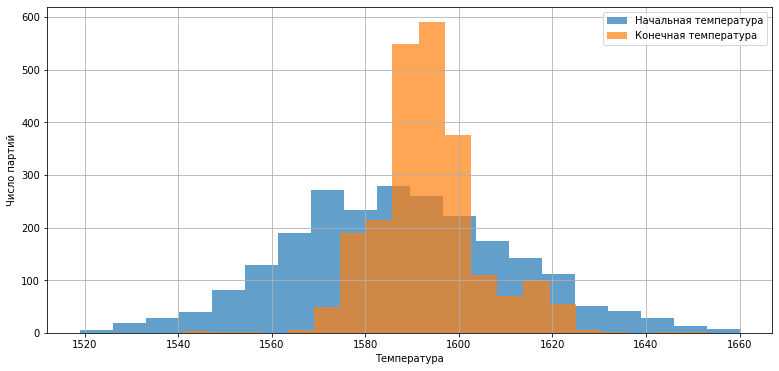

In [60]:
# Посмотрим на распределение начальных и конечных температур
plt.figure(figsize=(13,6))
first_last_temp.iloc[:,1].hist(bins=20, alpha=0.7);
first_last_temp.iloc[:,2].hist(bins=20, alpha=0.7);
plt.legend(['Начальная температура', 'Конечная температура']);
plt.xlabel('Температура');
plt.ylabel('Число партий');

<span style="color:green">
Можно видеть, что в среднем, матожидание конечная температуры чуть выше матожидания начальной. Дисперсия конечной температуры меньше дисперсии начальной
</span>

<span style="color:green">
Для таблицы с временами работы индукционных нагревочных дуг <b>data_arc</b> попробуем составить взаимосвязи между активной мощностью, реактивной мощностью и временем работы
</span>

In [61]:
data_arc['work_time'] = (data_arc['finish_arc_heating'] - data_arc['start_arc_heating']).dt.total_seconds()

In [62]:
corr_mat = data_arc[['active_power','reactive_power','work_time']].corr(method='pearson')
corr_mat

,active_power,reactive_power,work_time
active_power,1.000000,0.963182,0.974128
reactive_power,0.963182,1.000000,0.971269
work_time,0.974128,0.971269,1.000000


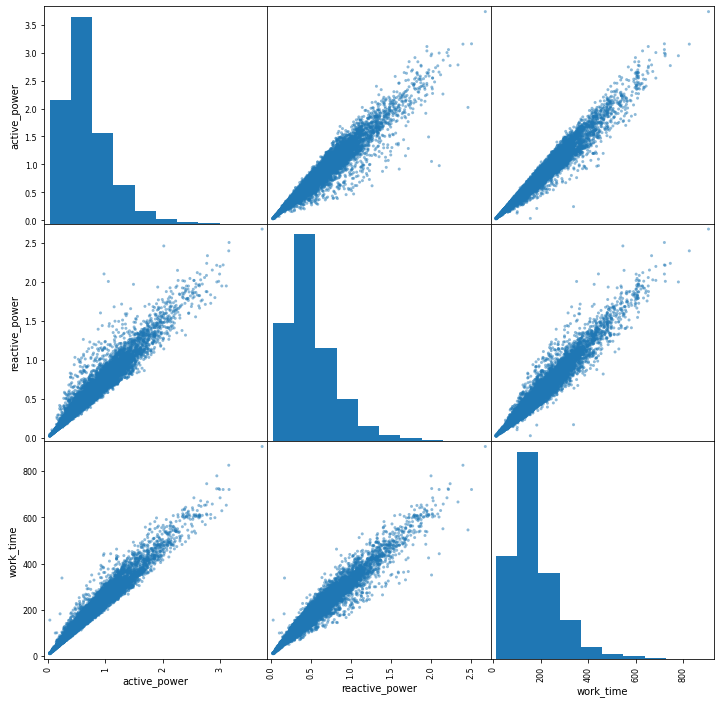

In [63]:
pd.plotting.scatter_matrix(data_arc[['active_power','reactive_power','work_time']], figsize=(12,12));

<span style="color:green">
Итак, три величины коррелируют между собой очень сильно. Даже более того, они связаны между собой линейными зависимостями. Поэтому имеет смысл сделать из них трех ровно одну. Например, полную работу системы, рассчитываему, как $t * sqrt(P^{2} + Q^{2})$, где t - время работы, P - активная мощность, Q - реактивная мощность
</span>

In [64]:
data_arc['work'] = data_arc['work_time']*np.sqrt(data_arc['active_power']*data_arc['active_power'] + data_arc['reactive_power']*data_arc['reactive_power'])

In [65]:
data_arc_work = data_arc.groupby(['key'])['work'].sum()
data_arc_work = data_arc_work.reset_index()

<span style="color:green">
В итоге объединяем все пять таблиц в одну финальную, чтобы отправить ее для дальнейших исследований
</span>

In [66]:
final_data = pd.merge(data_arc_work, first_last_temp, on='key')
final_data = pd.merge(final_data, data_gas, on='key')
final_data = pd.merge(final_data, data_bulk, on='key')
final_data = pd.merge(final_data, data_wire, on='key')

<span style="color:green">
Итоговый вид <b>final_bulk</b>
</span>

In [67]:
# Удалаяем поле 'key', так как оно, очевидным образом, никак не влияет на предсказание температуры
final_data = final_data.drop(['key'], axis=1)

In [68]:
final_data.head(5)

,work,first,last,gas,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_6
0,1442.377754,1571.0,1613.0,29.749986,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000,0.0
1,881.233565,1581.0,1602.0,12.555561,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,0.0
2,525.066777,1596.0,1599.0,28.554793,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000,0.0
3,796.911309,1601.0,1625.0,18.841219,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000,0.0
4,1199.137958,1576.0,1602.0,5.413692,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456,0.0


In [69]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2322 entries, 0 to 2321
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   work     2322 non-null   float64
 1   first    2322 non-null   float64
 2   last     2322 non-null   float64
 3   gas      2322 non-null   float64
 4   bulk_1   2322 non-null   float64
 5   bulk_3   2322 non-null   float64
 6   bulk_4   2322 non-null   float64
 7   bulk_6   2322 non-null   float64
 8   bulk_10  2322 non-null   float64
 9   bulk_11  2322 non-null   float64
 10  bulk_12  2322 non-null   float64
 11  bulk_14  2322 non-null   float64
 12  bulk_15  2322 non-null   float64
 13  wire_1   2322 non-null   float64
 14  wire_2   2322 non-null   float64
 15  wire_6   2322 non-null   float64
dtypes: float64(16)
memory usage: 308.4 KB


<span style="color:green">
<h3><b>2. Разработка модели</b></h3>
</span>

<span style="color:green">
Основной план дальнейших действий таков:<br><br>
- выделяем тренировочную и тестовую выборки в соотношении 3:1<br>
- нормализуем данные (примечание - для кросс-валидации каждый раз придется делать новую нормализацию)<br>
- берем в качестве базовых следующие алгоритмы: линейная регрессия, стохастический градиентный спуск, градиентный бустинг<br>
- с помощью кросс-валидации подбираем лучший из них на учебном датасете по метрике MAE<br>
- проверяем результаты на тестовой выборке, сравниваем рузальтат с dummy regression<br>
</span>

<span style="color:green">
Для начала выделим признаки и целевые значения из получившегося датасета
</span>

In [70]:
features = final_data.drop(['last'], axis=1)
target = final_data['last']

In [71]:
# Вводим инициатор случайного состояния
RANDOM_STATE = 151122
r_state = RandomState(RANDOM_STATE)

<span style="color:green">
Проверим <b>features</b> датасет на мультиколлинеарность
</span>

<span style="color:green">
Сначала осмотрим данные на предмет корреляции отдельных столбцов между собой
</span>

In [72]:
corr = final_data.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,work,first,last,gas,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_6
work,1.000000,-0.419759,0.275597,0.318909,0.067568,0.061431,-0.036345,0.128127,-0.002175,0.065909,0.480019,0.441507,0.308747,0.002717,0.015043,0.038112
first,-0.419759,1.000000,0.292112,0.032517,0.080008,-0.114883,0.165255,-0.128050,0.035548,-0.111136,-0.081441,-0.183638,-0.064377,0.264242,-0.101656,0.008559
last,0.275597,0.292112,1.000000,0.053847,-0.074316,-0.037828,0.189017,-0.184203,0.061565,-0.116940,0.269257,0.114032,0.267960,0.318726,-0.211199,-0.103452
gas,0.318909,0.032517,0.053847,1.000000,0.234626,0.059776,0.017724,0.139731,-0.008482,0.042129,0.218201,0.270511,0.043863,0.119037,0.104548,0.102237
bulk_1,0.067568,0.080008,-0.074316,0.234626,1.000000,-0.012007,0.042469,-0.006090,-0.023065,-0.037849,0.326395,0.206123,-0.001518,0.015824,-0.008856,0.153381
bulk_3,0.061431,-0.114883,-0.037828,0.059776,-0.012007,1.000000,-0.296818,0.064752,-0.085638,-0.007762,0.016262,0.007782,-0.015216,0.036454,0.094944,0.010683
bulk_4,-0.036345,0.165255,0.189017,0.017724,0.042469,-0.296818,1.000000,-0.252144,-0.085269,-0.119970,0.103915,-0.093894,0.099449,0.295729,-0.269423,-0.008185
bulk_6,0.128127,-0.128050,-0.184203,0.139731,-0.006090,0.064752,-0.252144,1.000000,-0.097329,0.196798,-0.114630,0.175744,-0.111023,-0.238259,0.204634,-0.018342
bulk_10,-0.002175,0.035548,0.061565,-0.008482,-0.023065,-0.085638,-0.085269,-0.097329,1.000000,-0.045707,0.027147,-0.046826,0.051495,0.061596,-0.104192,-0.016821
bulk_11,0.065909,-0.111136,-0.116940,0.042129,-0.037849,-0.007762,-0.119970,0.196798,-0.045707,1.000000,-0.040908,0.077682,-0.049083,-0.119784,0.061798,0.009884


<span style="color:green">
Итак, у нас наблюдается ощутимая взаимосвязь, между добавками <b>bulk_12</b> и <b>bulk_15/bulk_14</b><br>
Так же имеет место заметная корреляция суммарной работы электродов на расплав с объемами добавок <b>bulk_12</b>, <b>bulk_14</b> и <b>bulk_15</b><br><br>
Что до финальной температуры, которую мы должны предсказывать - она довольно сильно коррелирует (по модулю) с <b>work</b>, <b>first</b>, <b>bulk_4</b>, <b>bulk_6</b>, <b>bulk_12</b>, <b>bulk_15</b>, <b>wire_1</b> и <b>wire_2</b>
</span>

<span style="color:green">
Проведем анализ мультиколлинеарности компонент <b>work</b>, <b>first</b>, <b>bulk_4</b>, <b>bulk_6</b>, <b>bulk_12</b>, <b>bulk_15</b>, <b>wire_1</b> и <b>wire_2</b>, чтобы понять - можно ли вынести какие-либо из них из дальнейшего рассмотрения, чтобы результат предсказания последней температуры <b>last</b> был более предсказуемым
</span>

In [73]:
def get_vif(df, spec_features):
    vif, tolerance = {}, {}
    for spf in spec_features:
        X = [x for x in spec_features if x != spf]
        X, y = df[X], df[spf]

        r2 = LinearRegression().fit(X, y).score(X, y)
        tolerance[spf] = 1-r2
        vif[spf] = 1 / (tolerance[spf])

    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

spec_features = ['work', 'first','bulk_4', 'bulk_6', 'bulk_12', 'bulk_15', 'wire_1', 'wire_2']
result = get_vif(final_data, spec_features)
result

,VIF,Tolerance
work,1.660305,0.602299
first,1.356048,0.737437
bulk_4,1.212200,0.824946
bulk_6,1.172803,0.852658
bulk_12,1.968354,0.508039
bulk_15,1.611161,0.620670
wire_1,1.227541,0.814637
wire_2,1.114715,0.897090


<span style="color:green">
У нас довольно большое значение коэффициента инфляции отклонения VIF у <b>work</b>, <b>bulk_12</b>, <b>bulk_15</b>. Выясним, кто из них сильнее всего связан друг с другом, чтобы впоследствии исключить
</span>

In [74]:
# Исключаем work
spec_features = ['first','bulk_4', 'bulk_6', 'bulk_12', 'bulk_15', 'wire_1', 'wire_2']
get_vif(final_data, spec_features)

,VIF,Tolerance
first,1.116274,0.895837
bulk_4,1.212167,0.824969
bulk_6,1.136654,0.879775
bulk_12,1.645050,0.607884
bulk_15,1.610264,0.621016
wire_1,1.220712,0.819194
wire_2,1.114691,0.897109


In [75]:
# Исключаем bulk_12
spec_features = ['work', 'first','bulk_4', 'bulk_6', 'bulk_15', 'wire_1', 'wire_2']
get_vif(final_data, spec_features)

,VIF,Tolerance
work,1.387598,0.720670
first,1.345280,0.743340
bulk_4,1.211959,0.825111
bulk_6,1.161778,0.860749
bulk_15,1.152281,0.867844
wire_1,1.218710,0.820540
wire_2,1.113213,0.898301


In [76]:
# Исключаем bulk_15
spec_features = ['work', 'first','bulk_4', 'bulk_6', 'bulk_12', 'wire_1', 'wire_2']
get_vif(final_data, spec_features)

,VIF,Tolerance
work,1.659380,0.602635
first,1.355513,0.737728
bulk_4,1.211188,0.825635
bulk_6,1.170646,0.854229
bulk_12,1.407740,0.710358
wire_1,1.227539,0.814638
wire_2,1.113508,0.898063


<span style="color:green">
По этим результатам получаем, что если исключить из рассмотрения <b>bulk_12</b>, то мы снизим связанность <b>work</b> и <b>bulk_15</b>
Также обратим внимание, что исключая <b>work</b>, мы снижаем зависимость первоначальной температуры<br><br>
Теперь проверим связь <b>bulk_4</b> и <b>bulk_6</b>
</span>

In [77]:
# Исключаем bulk_4
spec_features = ['work', 'bulk_6', 'bulk_15', 'wire_1', 'wire_2']
get_vif(final_data, spec_features)

,VIF,Tolerance
work,1.139288,0.877741
bulk_6,1.137330,0.879252
bulk_15,1.148666,0.870575
wire_1,1.068895,0.935546
wire_2,1.050681,0.951764


In [78]:
# Исключаем bulk_6
spec_features = ['work', 'bulk_4', 'bulk_15', 'wire_1', 'wire_2']
get_vif(final_data, spec_features)

,VIF,Tolerance
work,1.112217,0.899105
bulk_4,1.181692,0.846244
bulk_15,1.136617,0.879804
wire_1,1.104572,0.905328
wire_2,1.085642,0.921114


<span style="color:green">
Чуть выгоднее исключить  <b>bulk_6</b><br><br>
Проверим связь <b>wire_1</b> и <b>wire_2</b>
</span>

In [79]:
# Исключаем wire_1
spec_features = ['work', 'bulk_4', 'bulk_15', 'wire_2']
get_vif(final_data, spec_features)

,VIF,Tolerance
work,1.111990,0.899289
bulk_4,1.088513,0.918684
bulk_15,1.127927,0.886582
wire_2,1.085392,0.921326


In [80]:
# Исключаем wire_2
spec_features = ['work', 'bulk_4', 'bulk_15', 'wire_1']
get_vif(final_data, spec_features)

,VIF,Tolerance
work,1.111157,0.899963
bulk_4,1.105746,0.904367
bulk_15,1.129006,0.885735
wire_1,1.104318,0.905537


<span style="color:green">
Опять же, исключние <b>wire_2</b> дает чуть лучший результат<br><br>
В итоге, мы удаляем из рассмотрения признак <b>bulk_6</b>, а такие признаки, как <b>first</b>, <b>bulk_12</b>, <b>wire_2</b> оставим, поскольку из удаление не сильно изменял коэффициент инфляции отклонения
</span>

In [81]:
features_mod = features.drop(['bulk_12'], axis=1)

<span style="color:green">
Разделим признаки и целевые значения на тренировочную и учебные части
</span>

In [82]:
features_train, features_test, target_train, target_test = train_test_split(
    features_mod, 
    target, 
    random_state=r_state, 
    test_size=0.25
    )

<span style="color:green">
Попробуем использовуть <b>Линейную регрессию</b> в качестве модели для предсказания финальной температуры
</span>

In [83]:
pipeline = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
scores = cross_val_score(pipeline, features_train, target_train, cv = 3, scoring='neg_mean_absolute_error')
print(f'MAE scores: {-scores},  mean MAE score: {np.mean(-scores)}')

MAE scores: [6.18327213 6.25554815 6.64188573],  mean MAE score: 6.360235336159332


<span style="color:green">
Простая линейная регрессия на кросс-валидации дала результат MAE=6.36
</span>

<span style="color:green">
Попробуем использовуть <b>SGD</b> в качестве модели для предсказания финальной температуры
</span>

In [84]:
pipeline = Pipeline([('scaler', StandardScaler()), ('model', SGDRegressor(random_state=RANDOM_STATE, penalty='l1'))])
scores = cross_val_score(pipeline, features_train, target_train, cv = 3, scoring='neg_mean_absolute_error')
print(f'MAE scores: {-scores},  mean MAE score: {np.mean(-scores)}')

MAE scores: [6.17949831 6.26768994 6.66632718],  mean MAE score: 6.37117181079994


<span style="color:green">
Чуть лучший результат, чем у линейной регрессии, результат дал алгоритм градиентного спуска
</span>

<span style="color:green">
Попробуем использовуть <b>Random Forest</b> в качестве модели для предсказания финальной температуры
</span>

In [85]:
param_grid = {'model__n_estimators': range(10,101,10), 'model__max_depth': range(5,21), 'model__min_samples_split': range(2,6), 'model__min_samples_leaf': range(1,4)}
pipeline_new = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=RANDOM_STATE))])
grid_search = GridSearchCV(pipeline_new, param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(features_train, target_train)
forest_params = grid_search.best_params_
forest_mae = grid_search.best_score_
print(f'Random Forest best params: {forest_params}')
print(f'Random Forest best MAE: {-forest_mae}')

Random Forest best params: {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Random Forest best MAE: 6.216554233925792


<span style="color:green">
<b>Лес девервьев решений</b> несколько улучшил результат по MAE, получив значение в 6.21
</span>

<span style="color:green">
Остается еще <b>LightGBM</b>
</span>

In [86]:
lgb_params = {"model__n_estimators" : range(40,201,10), "model__max_depth" : range(5,25)}
lgb_estimator = lgb.LGBMRegressor(random_state=r_state)
lgb_pipeline = Pipeline([('scaler', StandardScaler()), ('model', lgb_estimator)])
lgb_grid = GridSearchCV(lgb_pipeline, lgb_params, cv=3, scoring='neg_mean_absolute_error')
lgb_grid.fit(features_train, target_train)
best_lgb_params = lgb_grid.best_params_
best_lgb_mae = lgb_grid.best_score_
print(f'Gradient Boosting (not filled data) best params: {best_lgb_params}')
print(f'Gradient Boosting (not filled data) best MAE: {-best_lgb_mae}')

Gradient Boosting (not filled data) best params: {'model__max_depth': 5, 'model__n_estimators': 60}
Gradient Boosting (not filled data) best MAE: 6.13764480853659


<span style="color:green">
<b>Градиентный бустинг</b> сработал еще лучше, чем лес деревьев решений, MAE = 6.14
</span>

<span style="color:green">
Таким образом, по формальному признаку наименьшего MAE на обучающей выборке, мы должны взять модель градиентного бустинга с mae=6.14 и параметрами 'max_depth': 5, 'n_estimators': 60 и применить ее к тестовой выборке, чтобы оценить финальный результат.
</span>

<span style="color:green">
Но прежде, чем перейти к этому, попробуем провести дополнительный анализ компонент исходного датасета
</span>

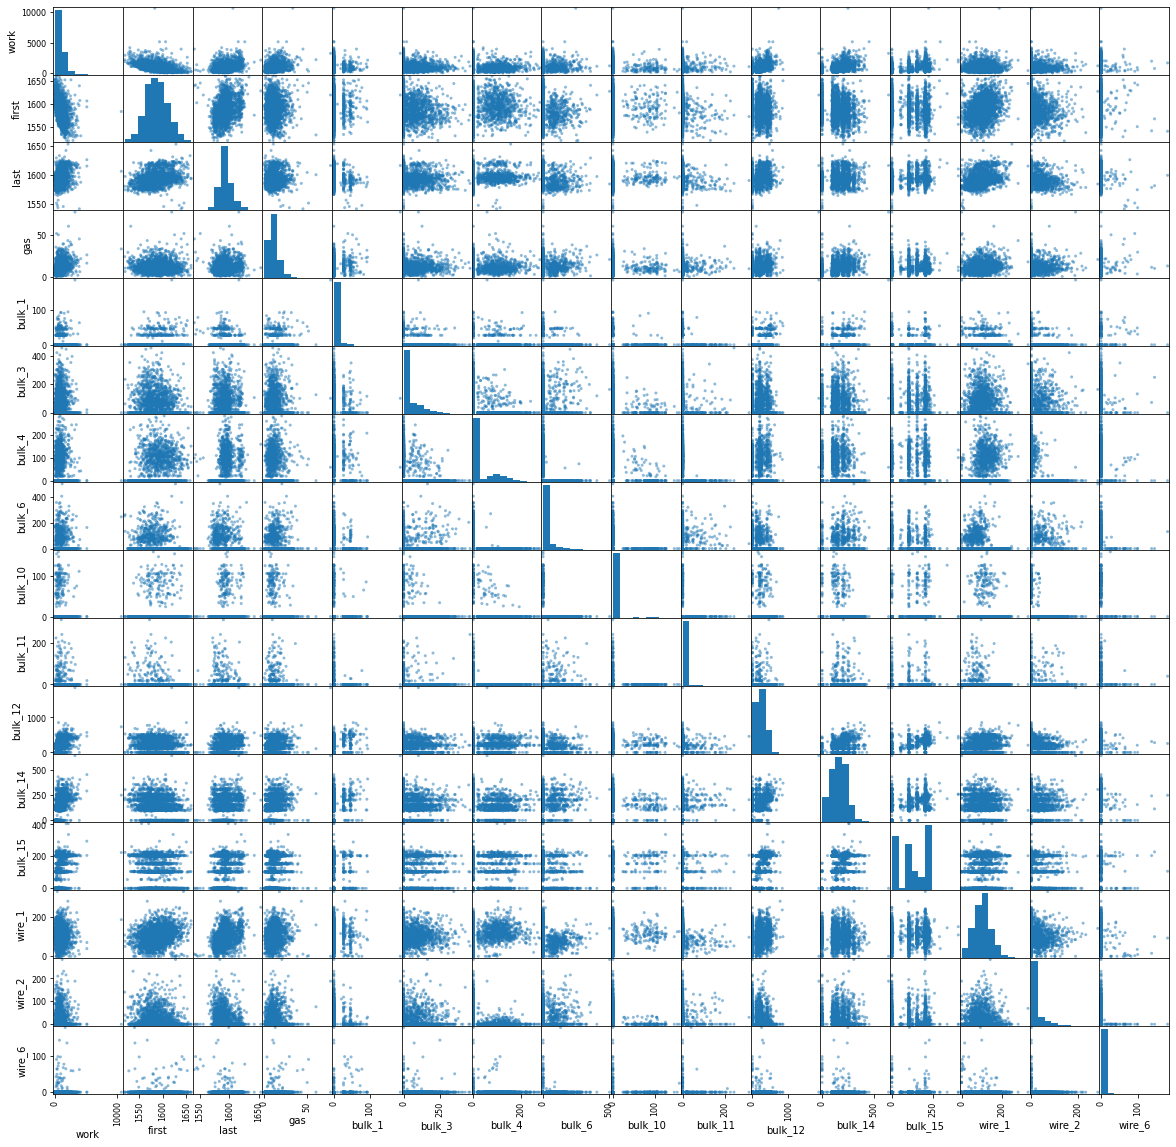

In [87]:
pd.plotting.scatter_matrix(final_data, figsize=(20,20));

<span style="color:green">
Интересное наблюдение - по <b>bulk_15</b> и немного по <b>bulk_1</b> имеет место кластеризация (4 кластера для bulk_15) по все параметрам. Возможно, стоит разработать модель, которая сначала находит кластер внутри bulk_15, а потом внутри него находит соотв. значения?
</span>

In [88]:
final_data_clust = final_data.copy()
array = np.array(final_data['bulk_15'])
model = KMeans(n_clusters=4, random_state=r_state)
model.fit(array.reshape(-1,1))
print(model.cluster_centers_)
final_data_clust['cluster'] = model.labels_

[[1.56311927e+02]
 [1.68789809e-01]
 [2.07898534e+02]
 [1.03020374e+02]]


In [89]:
train_dat, test_dat = train_test_split(final_data_clust, test_size=0.25, random_state=r_state)

In [90]:
train_dat.head(1)

,work,first,last,gas,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_6,cluster
301,1202.827775,1584.0,1601.0,13.854922,27.0,0.0,156.0,0.0,0.0,0.0,362.0,290.0,202.0,92.195999,0.0,0.0,2


In [91]:
train_dat_0 = train_dat.query('cluster == 0')
train_dat_f_0 = train_dat_0.drop(['last', 'bulk_15', 'cluster'], axis=1)
train_dat_t_0 = train_dat_0['last']

train_dat_1 = train_dat.query('cluster == 1')
train_dat_f_1 = train_dat_1.drop(['last', 'bulk_15', 'cluster'], axis=1)
train_dat_t_1 = train_dat_1['last']

train_dat_2 = train_dat.query('cluster == 2')
train_dat_f_2 = train_dat_2.drop(['last', 'bulk_15', 'cluster'], axis=1)
train_dat_t_2 = train_dat_2['last']

train_dat_3 = train_dat.query('cluster == 3')
train_dat_f_3 = train_dat_3.drop(['last', 'bulk_15', 'cluster'], axis=1)
train_dat_t_3 = train_dat_3['last']

test_dat_0 = test_dat.query('cluster == 0')
test_dat_f_0 = test_dat_0.drop(['last', 'bulk_15', 'cluster'], axis=1)
test_dat_t_0 = test_dat_0['last']

test_dat_1 = test_dat.query('cluster == 1')
test_dat_f_1 = test_dat_1.drop(['last', 'bulk_15', 'cluster'], axis=1)
test_dat_t_1 = test_dat_1['last']

test_dat_2 = test_dat.query('cluster == 2')
test_dat_f_2 = test_dat_2.drop(['last', 'bulk_15', 'cluster'], axis=1)
test_dat_t_2 = test_dat_2['last']

test_dat_3 = test_dat.query('cluster == 3')
test_dat_f_3 = test_dat_3.drop(['last', 'bulk_15', 'cluster'], axis=1)
test_dat_t_3 = test_dat_3['last']


<span style="color:green">
Теперь попробуем применить те же регрессионные алгоритмы, но ориентированные каждый к отдельному кластеру
</span>

<span style="color:green">
Кластерная <b>линейная регрессия</b>
</span>

In [92]:
pipeline_lreg_0 = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
scores_0 = cross_val_score(pipeline_lreg_0, train_dat_f_0, train_dat_t_0, cv = 3, scoring='neg_mean_absolute_error')
print(f'Cluster 0: MAE scores: {-scores_0},  mean MAE score: {np.mean(-scores_0)}')

pipeline_lreg_1 = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
scores_1 = cross_val_score(pipeline_lreg_1, train_dat_f_1, train_dat_t_1, cv = 3, scoring='neg_mean_absolute_error')
print(f'Cluster 1: MAE scores: {-scores_1},  mean MAE score: {np.mean(-scores_1)}')

pipeline_lreg_2 = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
scores_2 = cross_val_score(pipeline_lreg_2, train_dat_f_2, train_dat_t_2, cv = 3, scoring='neg_mean_absolute_error')
print(f'Cluster 2: MAE scores: {-scores_2},  mean MAE score: {np.mean(-scores_2)}')

pipeline_lreg_3 = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
scores_3 = cross_val_score(pipeline_lreg_3, train_dat_f_3, train_dat_t_3, cv = 3, scoring='neg_mean_absolute_error')
print(f'Cluster 3: MAE scores: {-scores_3},  mean MAE score: {np.mean(-scores_3)}')

print(f'Total mean: {np.mean(np.array([np.mean(-scores_0), np.mean(-scores_1), np.mean(-scores_2), np.mean(-scores_3)]))}')

Cluster 0: MAE scores: [7.06789052 6.218033   7.17903717],  mean MAE score: 6.821653563805433
Cluster 1: MAE scores: [5.68534661 5.70494974 6.74349675],  mean MAE score: 6.044597702339499
Cluster 2: MAE scores: [6.51198996 7.00771977 6.85238609],  mean MAE score: 6.7906986081353296
Cluster 3: MAE scores: [5.32692596 5.56333788 6.43260596],  mean MAE score: 5.7742899312731195
Total mean: 6.3578099513883455


<span style="color:green">
Кластерный <b>SGD</b>
</span>

In [93]:
pipeline_sgd_0 = Pipeline([('scaler', StandardScaler()), ('model', SGDRegressor(random_state=RANDOM_STATE, penalty='l1'))])
scores_0 = cross_val_score(pipeline_sgd_0, train_dat_f_0, train_dat_t_0, cv = 3, scoring='neg_mean_absolute_error')
print(f'Cluster 0: MAE scores: {-scores_0},  mean MAE score: {np.mean(-scores_0)}')

pipeline_sgd_1 = Pipeline([('scaler', StandardScaler()), ('model', SGDRegressor(random_state=RANDOM_STATE, penalty='l1'))])
scores_1 = cross_val_score(pipeline_sgd_1, train_dat_f_1, train_dat_t_1, cv = 3, scoring='neg_mean_absolute_error')
print(f'Cluster 1: MAE scores: {-scores_1},  mean MAE score: {np.mean(-scores_1)}')

pipeline_sgd_2 = Pipeline([('scaler', StandardScaler()), ('model', SGDRegressor(random_state=RANDOM_STATE, penalty='l1'))])
scores_2 = cross_val_score(pipeline_sgd_2, train_dat_f_2, train_dat_t_2, cv = 3, scoring='neg_mean_absolute_error')
print(f'Cluster 2: MAE scores: {-scores_2},  mean MAE score: {np.mean(-scores_2)}')

pipeline_sgd_3 = Pipeline([('scaler', StandardScaler()), ('model', SGDRegressor(random_state=RANDOM_STATE, penalty='l1'))])
scores_3 = cross_val_score(pipeline_sgd_3, train_dat_f_3, train_dat_t_3, cv = 3, scoring='neg_mean_absolute_error')
print(f'Cluster 3: MAE scores: {-scores_3},  mean MAE score: {np.mean(-scores_3)}')

print(f'Total mean: {np.mean(np.array([np.mean(-scores_0), np.mean(-scores_1), np.mean(-scores_2), np.mean(-scores_3)]))}')

Cluster 0: MAE scores: [7.05397117 6.21847898 7.15976308],  mean MAE score: 6.810737745635655
Cluster 1: MAE scores: [5.68272916 5.70194316 6.75951985],  mean MAE score: 6.0480640571182365
Cluster 2: MAE scores: [6.53248352 7.00832851 6.90694924],  mean MAE score: 6.815920423320825
Cluster 3: MAE scores: [5.32640812 5.56567307 6.43302146],  mean MAE score: 5.775034217730059
Total mean: 6.362439110951194


<span style="color:green">
Кластерный <b>SGD</b> получился чуть хуже <b>линейной регрессии</b>, но не намного
</span>

<span style="color:green">
Кластерный вариант <b>градиентного бустинга</b>
</span>

In [94]:
# create models for each cluster
# cluster 0
lgb_params_0 = {"model__n_estimators" : range(40,201,10), "model__max_depth" : range(5,25)}
lgb_estimator_0 = lgb.LGBMRegressor(random_state=r_state)
lgb_pipeline_0 = Pipeline([('scaler', StandardScaler()), ('model', lgb_estimator_0)])
lgb_grid_0 = GridSearchCV(lgb_pipeline_0, lgb_params_0, cv=3, scoring='neg_mean_absolute_error')
lgb_grid_0.fit(train_dat_f_0, train_dat_t_0)
best_lgb_params_0 = lgb_grid_0.best_params_
best_lgb_mae_0 = lgb_grid_0.best_score_
print(f'Gradient Boosting (not filled data) best params: {best_lgb_params_0}')
print(f'Gradient Boosting (not filled data) best MAE: {-best_lgb_mae_0}')

# create models for each cluster
# cluster 1
lgb_params_1 = {"model__n_estimators" : range(40,201,10), "model__max_depth" : range(5,25)}
lgb_estimator_1 = lgb.LGBMRegressor(random_state=r_state)
lgb_pipeline_1 = Pipeline([('scaler', StandardScaler()), ('model', lgb_estimator_1)])
lgb_grid_1 = GridSearchCV(lgb_pipeline_1, lgb_params_1, cv=3, scoring='neg_mean_absolute_error')
lgb_grid_1.fit(train_dat_f_1, train_dat_t_1)
best_lgb_params_1 = lgb_grid_1.best_params_
best_lgb_mae_1 = lgb_grid_1.best_score_
print(f'Gradient Boosting (not filled data) best params: {best_lgb_params_1}')
print(f'Gradient Boosting (not filled data) best MAE: {-best_lgb_mae_1}')

# create models for each cluster
# cluster 2
lgb_params_2 = {"model__n_estimators" : range(40,201,10), "model__max_depth" : range(5,25)}
lgb_estimator_2 = lgb.LGBMRegressor(random_state=r_state)
lgb_pipeline_2 = Pipeline([('scaler', StandardScaler()), ('model', lgb_estimator_2)])
lgb_grid_2 = GridSearchCV(lgb_pipeline_2, lgb_params_2, cv=3, scoring='neg_mean_absolute_error')
lgb_grid_2.fit(train_dat_f_2, train_dat_t_2)
best_lgb_params_2 = lgb_grid_2.best_params_
best_lgb_mae_2 = lgb_grid_2.best_score_
print(f'Gradient Boosting (not filled data) best params: {best_lgb_params_2}')
print(f'Gradient Boosting (not filled data) best MAE: {-best_lgb_mae_2}')

# create models for each cluster
# cluster 3
lgb_params_3 = {"model__n_estimators" : range(40,201,10), "model__max_depth" : range(5,25)}
lgb_estimator_3 = lgb.LGBMRegressor(random_state=r_state)
lgb_pipeline_3 = Pipeline([('scaler', StandardScaler()), ('model', lgb_estimator_3)])
lgb_grid_3 = GridSearchCV(lgb_pipeline_3, lgb_params_3, cv=3, scoring='neg_mean_absolute_error')
lgb_grid_3.fit(train_dat_f_3, train_dat_t_3)
best_lgb_params_3 = lgb_grid_3.best_params_
best_lgb_mae_3 = lgb_grid_3.best_score_
print(f'Gradient Boosting (not filled data) best params: {best_lgb_params_3}')
print(f'Gradient Boosting (not filled data) best MAE: {-best_lgb_mae_3}')

print(f'Total mean: {np.mean(np.array([-best_lgb_mae_0, -best_lgb_mae_1, -best_lgb_mae_2, -best_lgb_mae_3]))}')

Gradient Boosting (not filled data) best params: {'model__max_depth': 5, 'model__n_estimators': 40}
Gradient Boosting (not filled data) best MAE: 7.196054984442377
Gradient Boosting (not filled data) best params: {'model__max_depth': 6, 'model__n_estimators': 40}
Gradient Boosting (not filled data) best MAE: 6.397385866277631
Gradient Boosting (not filled data) best params: {'model__max_depth': 5, 'model__n_estimators': 40}
Gradient Boosting (not filled data) best MAE: 6.913152512376674
Gradient Boosting (not filled data) best params: {'model__max_depth': 7, 'model__n_estimators': 40}
Gradient Boosting (not filled data) best MAE: 5.814719625695484
Total mean: 6.580328247198041


<span style="color:green">
В кластерном варианте <b>градиентный бустинг</b>, <b>SGD</b> и <b>линейная регрессия</b> показали неплохие результаты, но не улучшающие результат на обычной учебной выборке. Тем не менее, по итогам всех численных экспериментов, лучшее значение MAE показал обычный <b>LightGBM</b> с результатом в 6.14. Используем его для проверки тестового датасета и сравним результат его работы с <b>наивным<b> алгоритмом регрессии
</span>

In [96]:
pipeline = Pipeline([('scaler', StandardScaler()), ('model', lgb.LGBMRegressor(random_state=RANDOM_STATE, n_estimators=60, max_depth=5))])
pipeline.fit(features_train, target_train)
target_predict = pipeline.predict(features_test)
result = mean_absolute_error(target_test, target_predict)
print(f'SGD result MAE: {result}')

# Наивный (dummy) алгоритм регрессии
dummy_rougher = DummyRegressor(strategy='mean')
dummy_rougher.fit(features_train, target_train)
dummy_predict = dummy_rougher.predict(features_test)
dummy_rougher_smape = mean_absolute_error(target_test, dummy_predict)
print(f'Dummy regressor MAE: {dummy_rougher_smape}')

SGD result MAE: 6.030392836948565
Dummy regressor MAE: 8.300142063288847


<span style="color:green">
Выводы.<br><br>
Результат Random Forest получился лучше, чем Dummy regressor- это обнадеживает, что все было не зря<br>
Абсолютная ошибка Random Forest равна 6.031. В принципе достигнут целевой результат<br>
</span>

<span style="color:green">
<h3><b>3. Отчет</b></h3>
</span>

<span style="color:green">
<h3><b>Итоги работы: первоначальная постановка задачи, исходные данные</b></h3>
В данной работе решалась задача экономии энергопотребления металлургического завода путем расчета оптимальной выходной температуры сплава стали, в зависимости от входных данных: начальная температура расплава, активная/рективная мощность электродов печи, объем используемых инертных газов, объемы легирующих добавок россыпью и в виде проволоки. При этом технологический процеесс варки стали должен состоять из четырех зацикленных этапов: повышение температуры расплава -> добавление в расплав легирующих добавок -> пропуск инертных газов через расплав -> измерение температуры.<br><br>
Изначальный датасет состоял из семи таблиц, содержавших следующие данные: данные об электродах, данные о подаче сыпучих материалов (объём), данные о подаче сыпучих материалов (время), данные о продувке сплава газом, результаты измерения температуры, данные о проволочных материалах (объём), данные о проволочных материалах (время)
<br><br>

<h3><b>Итоги работы: этап 1 - сбор, обработка и подготовка данных</b></h3>

Этап обработки данных содержал в себе следующие запланированные разделы:<br>
<b>Раздел 1</b>. Считать все данные по задаче из .csv файлов<br>
<b>Раздел 2</b>. Анализировать данные, ищем в них аномалии, выбрасить нерелевантные данные, анализировать скрытые зависимости с помощью графиков<br>
<b>Раздел 3</b>. Принять решение, какие данные оставляем для работы<br>
<b>Раздел 4</b>. Построить датасет на основе выбранных данных<br>
<br>
Основными сложностями (из которых вытекали соответсвующие требования), которые могли возникнуть с даннами на <b>этапе 1</b>
- могли быть пропуски данных, хотя очевидно, что все данные должны быть вещественными числами, значения вида NaN не допускаются - к счастью, когда таковые значения относились к объемам добавок и их можно было обнулить<br>
- могли быть аномальные значения числовых параметров - в этом случае необходимо было их или восстановить согласно соседним данным, либо отбросить как недостоверные. Пример недостоверных данных, не подлежащих восстановлению - аномально низкие температуры стального расплава<br>
- бщим ключом для всех таблиц данных была величина <b>key</b> - номер партии, где производилась варка стали. Необходимо было включить в датасет только те партии, где производился замер температуры в начале и в конце процесса, где добавляли легирующие добавки, где осуществлялась газация расплава и где происходил нагрев расплава электродами. 

<br>Покажем, что было сделано в каждом запланированном разделе:<br><br>

<b>Раздел 1</b>. Все данные были успешно считаны и представлены в виде pandas таблиц<br>

<b>Раздел 2</b>. С помощью анализа данных было обнаружено, что данные о времени добавки легирующих материалов и проволоки не требуются для построения модели. Единичные аномальные значения содержались в темепратуре расплава и реактивной мощности плавильных электродов (в первом случае нерелевантные данные были удалены - во втором восстановлены). Данные по использованным газам показали, что газ использовался не для всех партий - следовательно, из рассмотрения следовало исключить партии, где инертных газов не было. Ряд легирующих добавок/проволоки попадался довольно редко, так что их было решено исключить, чтобы они не ухудшали прогностическую модель. В таблице замеров температуры расплава не всегда было начальное и финальное значение температуры, а поскольку нас интересовали именно они, нерелевантные партии также пришлось убрать из рассмотрения. В таблице по времени работы и можностям электродов было установлено, что время работы, активная и реактивная мощности сильно коррелируют между собой и оказалось целесообразней заменить их суммарным значением работы<br>

<b>Раздел 3</b>. Итоговый датасет для обучения состоял из следующих значений: <b>work</b> - суммарная работа электродов для каждой партии, <b>first</b> - начальная темепература расплава, <b>last</b> - конечная температура расплава, <b>gas</b> - объем добавленного инертного газа, <b>bulk_1, bulk_3, bulk_4, bulk_6, bulk_10, bulk_11, bulk_12, bulk_14, bulk_15</b> - объемы сыпучих добавок номер 1,3,4,6,10,12,14,15 соответсвенно, <b>wire_1, wire_2, wire_6</b> - объемы добавляемых проволок, номер 1,2 и 6<br>

<b>Раздел 4</b>. Исходя из рассуждения предыдущих двух пунктов был подготовлен датасет для построения предиктивной модели<br><br>
Таким образом, все заявленные пункты <b>этапа 1</b> были реализованы и можно было переходить к следующему пункту, построению предиктивной модели конечной температуры расплава.
<br><br>

<h3><b>Итоги работы: этап 2 - построение моделей, обучение их на подготовленном датасете</b></h3>

На этапе разработке модели предсказания температур были обозначены следующие шаги, которые было необходимо выполнить для полноценного решения задачи:<br><br>

<b>Шаг 1</b>. Сформировать учебную и тестовые выборки данных<br>
<b>Шаг 2</b>. Предлажить метрику оценки предсказательной модели<br>
<b>Шаг 3</b>. Нормализовать данные<br>
<b>Шаг 4</b>. Выбирать регрессионный алгоритм<br>
<b>Шаг 5</b>. С помощью кросс-валидации на тренировочных данных выбрать наилучший алгоритм<br>
<b>Шаг 6</b>. Применить тестовую выборку из датасета на наилучшей модели<br>
<br>

Обратим внимание на основные сложности, которые могли возникнуть при выборе алгоритмов предсказания финальной температуры.
Во первых, заранее неизвестно, какие параметры имеют большее влияние на финальную температуру, какие меньше? Имеет ли место внутрення кластеризация данных по одному или нескольким параметрам? Связаны ли между собой группы параметров, и  можно ли их в этом случае заменить линейной комбинацией? Насколько сильно "зашумлены" данные, применима ли к ним линейная регрессия, или зависимсоть имеет более сложных характер. Частично, эти вопросы были решены на этапах нормировки и проверки на мультиколлинеарность данных.<br>
Во вторых, не зная внутренние взаимосвязи в датасете, заранее нельзя было предугадать какой регрессионный алгоритм стоит применить к задаче, поэтому спектр возможных инструментов уже включал в себя все, начиная от линейной регрессии и заканчивая нейронной сетью с несколькими скрытыми слоями (в итоге было решено ее не рассматривать, так как подбор оптимальной архитектуры мог занять неопределенное количество времени). Поэтому пришлось перебрать все наиболее известные алгоритмы<br>
Во третьих, даже выбрав ряд потенциальных алгоритмов, необходимо было подобрать их внешние параметры так, чтобы минимизировать среднюю абсолютную ошибку предсказания. Впрочем, при наличии достаточного времени, можно было подобрать оптимальные параметры алгоритмов (например, для леса деревьев - число деревьев, их глубина, степень ветвления и т.д.) с помощью решетчатого поиска параметров.


<br><br>

<b>Шаг 1</b> В первом пункте, с помощью функции sklearn - train_test_split() сформированный датасет был разбит на тренировочную и тестовую части в соотношении 75% к 25%. Для инициации случаного состояния здесь и далее была использована константа 151122. В качестве исходных параметров были взяты <b>work</b>, <b>first</b>, <b>gas</b>, <b>bulk_1, bulk_3, bulk_4, bulk_6, bulk_10, bulk_11, bulk_12, bulk_14, bulk_15</b>, <b>wire_1, wire_2, wire_6</b>. В качестве целевого признака - температура <b>last</b><br><br>

<b>Шаг 2</b> В качестве контрольной метрики для проверки качества предиктивных алгоритмов была выбрана <b>средняя абсолютная ошибка</b> MAE температуры - как более устойчивой к выбросам и лучше масштабируемую при изменении диапазона температур плавления<br><br>

<b>Шаг 3</b> На третьем этапе было решено нормировать данные тренировочной выборки с помощью функции StandardScaler() из комплекта sklearn. Для того, чтобы можно было производить масштабирование исходных параметров, а также передавать стандартизированные данные в регрессионный алгоритм, использовался пайплайн вида <b>Pipeline([('scale', StandardScaler()), ('model', RegressionModel())])</b>
Прежде чем переходить к работе на регрессионных алгоритмах, данные были дополнительно проверены на мультиколлинеарность - то есть зависимость одних параметров/признака от линейной комбинации остальных параметров. В нашем случае оказалось, что параметр <b>bulk_12</b> - объем сыпучего легирующего вещества №12 можно было убрать, чтобы снизить взаимовлияние других параметров друг между другом, что дало бы большую устойчивость регрессионной модели<br><br>
<b>Шаг 4</b> В качестве регрессионных алгоритмов были опробованы на тренировочных данных следующие: <br>
- Линейная регрессия - LinearRegression()<br>
- Стохастический градиентный спуск - SGDRegressor()<br>
- Лес деревьев решений - RandomForestRegressor()<br>
- Алгоритм градиентного бустинга - реализация в библиотеке LightGBM LGBMRegressor()<br>
- Наивный регрессионный алгоритм - DummyRegressor() для поверки адекватности вышеперечисленных предиктивных алгоритмов. В качестве "предсказания" значения температуры используется среднее ее значение из тренировочного датасета<br>

<b>Шаг 5</b> Проверка предложенных алгоритмов и их донастройка на тренировочной выборке осуществяллась таким образом:<br> 
1. Для линейной регрессии осущетсвлялась с кросс-валидацией при разбивке датасета на три части - итоговое среднее значение MAE = 6.36<br>
2. Стохастический градиентный спуск также проверялся с помощью кросс-валидации при разбивке датасета на три части, а входными параметрами были начальное случайное значение RANDOM_STATE = 151122, и функция штрафа = L1. Итоговое значение MAE = 6.37<br>
3. Для леса деревьев решений был осуществлен решетчатый поиск таких входных параметров, как <b>число деревьев</b> от 10 до 101 с шагом 10, <b>максимальная глубина дерева</b> - в диапазоне от 5 до 20, <b>минимальное число выборок для разделеня внутреннего узла дерева</b> от 2 до 5, <b>минимальное число выборок для получения листа дерева</b> от 1 до 3. Параметр случайного состояния RANDOM_STATE = 151122. К этому все добавилась и кросс-валидационная провека с кадым набором параметров при разбивке датасета на три части - лучшее значение MAE = 6.21, при кол-ве деревьев=100, максимальной глубине=10, числе выборок на ветвление=2 и числе выборок на получение оконечного листа=3<br>
4. Градиентный бустинг, где решетчатым поиском подбиралось оптимальное число деревьев от 40 до 201 с шагом в 10 и максимальной глубиной дерева от 5 до 24. Параметр случайного состояния RANDOM_STATE = 151122. Опять же с кросс-валидационной проверкой. В итоге лучшее значение MAE = 6.14, при числе деревьев = 60 и их максимальной глубине 5<br><br>

<b>Шаг 6</b> По результатам проверки на тренировочном датасете, в качестве рабочей модели был взят градиентный бустинг (Оптимальные найденные параметры - число деревьев в лесу равно 60, максимальная глубина дерева = 5). На тестовых данных он дал MAE, равное 6.031. При этом проверочный dummy-алгоритм, дающий в качестве предсказываемого значения среднюю конечную температуру тренировочного датасета, выдал MAE, равный 8.3 - то есть налицо адекватность применимости нами предиктивных методик для получения конечной температуы расплава при заданных параметрах процесса производства стали<br>
Итак все запланированные пункты <b>второго этапа</b> также были выполнены в полном объеме<br><br>
По результатам работы был написан краткий отчет.
</span>